In [10]:
# imports
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import tensorflow as tf

In [11]:
# architecture of CNN
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # there are 16 filters

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # there are 36 filters

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [13]:
# split data into train, test and validation 
print("training-set:\t{}".format(len(data.train.labels)))  
print("testset:\t{}".format(len(data.test.labels)))
print("validationset:\t{}".format(len(data.validation.labels)))

training-set:	55000
testset:	10000
validationset:	5000


In [14]:
# getting the integer values of the class labels
data.test.cls = np.argmax(data.test.labels, axis = 1)

In [15]:
img_size = 28 # image size of MNIST

img_size_flat = img_size * img_size # store images in an array 

img_shape = (img_size, img_size)

num_channels = 1 # only 1 color channel (gray scale)

num_classes = 10 # number of classes 

In [16]:
# helper plotting function 
def plot_images(images, cls_true, cls_pred = None):
#     assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap = 'binary')
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        ax.set_xlabel(xlabel)        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

In [17]:
# helper funciton for weight initialization 
def new_weights(shape):
    return tf. Variable(tf.truncated_normal(shape, stddev = 0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape = [length]))

In [18]:
# creating convolutional layer 
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):  

    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # create weights/filters 
    weights = new_weights(shape=shape)

    # bias for each filter 
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input = input, filter = weights, strides = [1,1,1,1], padding = 'SAME')

    layer += biases # adding bias to the result of each convolution 

    # pooling to downsample resolution 
    if use_pooling:
        layer = tf.nn.max_pool(value = layer, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')
    layer = tf.nn.relu(layer)
    return layer, weights

In [19]:
# flattening convolution outputs 
def flatten_layer(layer):
    layer_shape = layer.get_shape() # obtain the shape of the input layer 
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [20]:
# creating new fully-connected layer 
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True): 
    # biases and weights 
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    # using RELU to introduce non-linearity 
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [21]:
# create a placeholder fot to hold the input images 
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name = 'x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [22]:
# the first convolutinal layer 
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image, num_input_channels=num_channels, filter_size=filter_size1,
                   num_filters=num_filters1, use_pooling=True)

In [23]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, filter_size=filter_size2,
                   num_filters=num_filters2, use_pooling=True)

In [24]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [25]:
# first FC layer
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)

In [26]:
# second FC layer
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)

In [27]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis = 1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy) # taking an average of the cross entropy for all images
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-4).minimize(cost) # using the AdamOptimizer
correct_prediction = tf.equal(y_pred_cls, y_true_cls) # measure preduction accuracy 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))  # obtain the accuracy 


In [28]:
# create a TF session
session = tf.Session()
# initialize varibales 
session.run(tf.global_variables_initializer())
train_batch_size = 64 # set batch size

In [29]:
# helper function to perform optimization iteration 
total_iterations = 0 # count the number of iterations
def optimize(num_iterations):
    global total_iterations

    start_time = time.time()  # time the optimization 

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0: # every 100 iterations, print the status of the performance
            acc = session.run(accuracy, feed_dict=feed_dict_train) # training set accuracy 
            msg = "Optimization Pass: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time() # ending time
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [30]:
# ploting some examples that were misclassified 
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)

    images = data.test.images[incorrect] # misclassified images    
    cls_pred = cls_pred[incorrect] # obtain predictions
    cls_true = data.test.cls[incorrect] # true classes 
    
    # plot a few images
    plot_images(images=images[0:9], cls_true=cls_true[0:9], cls_pred=cls_pred[0:9])

In [31]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls

    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred) # obtain confusion matrix using sklearn

    # Print the confusion matrix as text.
    print(cm)

In [32]:
test_batch_size = 256
def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

    num_test = len(data.test.images)
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test) # last index of the next batch

        images = data.test.images[i:j, :] # images between i and j

        labels = data.test.labels[i:j, :] # get labels

        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict) # obtain the predicted class

        i = j

    cls_true = data.test.cls # true class numbers

    correct = (cls_true == cls_pred)
    correct_sum = correct.sum() # number of correctly classified images 

    acc = float(correct_sum) / num_test # testset accuracy

    msg = "Accuracy on testet: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("misclassified images:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("confusion matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [33]:
# performance after 1000 optimization iterations
optimize(num_iterations=1000) # We performed 100 iterations above.

Optimization Pass:      1, Training Accuracy:   9.4%
Optimization Pass:    101, Training Accuracy:  67.2%
Optimization Pass:    201, Training Accuracy:  90.6%
Optimization Pass:    301, Training Accuracy:  81.2%
Optimization Pass:    401, Training Accuracy:  87.5%
Optimization Pass:    501, Training Accuracy:  90.6%
Optimization Pass:    601, Training Accuracy:  89.1%
Optimization Pass:    701, Training Accuracy:  92.2%
Optimization Pass:    801, Training Accuracy:  98.4%
Optimization Pass:    901, Training Accuracy:  90.6%
Time usage: 0:01:27


Accuracy on testet: 93.0% (9305 / 10000)
misclassified images:


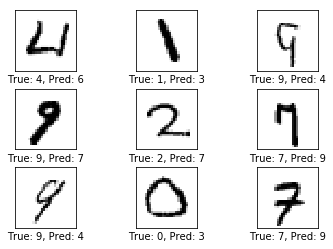

In [34]:
print_test_accuracy(show_example_errors=True)

In [35]:
# perfrmance after 10000 optimization iterations
optimize(num_iterations=9000) # already perfromed 1000 iterations above

Optimization Pass:   1001, Training Accuracy:  87.5%
Optimization Pass:   1101, Training Accuracy:  98.4%
Optimization Pass:   1201, Training Accuracy:  87.5%
Optimization Pass:   1301, Training Accuracy:  90.6%
Optimization Pass:   1401, Training Accuracy:  92.2%
Optimization Pass:   1501, Training Accuracy:  93.8%
Optimization Pass:   1601, Training Accuracy:  90.6%
Optimization Pass:   1701, Training Accuracy:  96.9%
Optimization Pass:   1801, Training Accuracy:  95.3%
Optimization Pass:   1901, Training Accuracy:  96.9%
Optimization Pass:   2001, Training Accuracy:  96.9%
Optimization Pass:   2101, Training Accuracy:  95.3%
Optimization Pass:   2201, Training Accuracy:  98.4%
Optimization Pass:   2301, Training Accuracy:  93.8%
Optimization Pass:   2401, Training Accuracy:  90.6%
Optimization Pass:   2501, Training Accuracy: 100.0%
Optimization Pass:   2601, Training Accuracy:  96.9%
Optimization Pass:   2701, Training Accuracy:  98.4%
Optimization Pass:   2801, Training Accuracy: 

Accuracy on testet: 98.6% (9856 / 10000)
misclassified images:


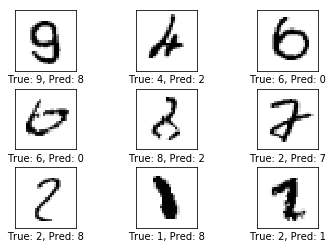

confusion matrix:
[[ 974    0    1    0    0    0    2    0    2    1]
 [   0 1126    2    0    0    0    2    1    4    0]
 [   4    1 1014    3    1    0    0    3    6    0]
 [   0    0    1 1005    0    1    0    0    3    0]
 [   1    0    2    0  968    0    1    0    2    8]
 [   2    0    1   10    0  871    3    1    3    1]
 [   6    2    0    1    1    1  946    0    1    0]
 [   1    4    7    3    0    0    0 1006    4    3]
 [   4    0    1    3    1    1    0    1  960    3]
 [   3    4    0    5    5    1    1    1    3  986]]


In [36]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

In [37]:
session.close()